In [1]:
import numpy as np
import pandas as pd
import os
import re
import warnings
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
os.getcwd()

'C:\\Users\\keato\\Documents\\LocalRStudio\\LJ_Leading_Indicators'

In [3]:
from thon.Choose import choose_features
from thon.churn import rollover, save_model, tree_importance, plot_eval, bake_pred
data = choose_features("data/out/features.csv", cv_range = (0, 10), save = False)

C:\Users\keato\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\keato\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
C:\Users\keato\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.025e+05, tolerance: 4.235e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solver

Alpha estimate: {'model__alpha': 6.0}
8 features selected 



In [4]:
#data = pd.read_csv("data/out/features.csv")

In [5]:
data.columns

Index(['month', 'n', 'altsales_lag3', 'durable_lag9', 'miles_lag12',
       'newhouses_lag3', 'ngf_lag12', 'XOM_lag12'],
      dtype='object')

In [6]:
# Training data
X, y = data.drop(columns = ['n']), data['n']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, shuffle = False)

In [7]:
# Training data

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Store the fitted values as a time series with the same time index as
# the training data
train_pred = pd.Series(model.predict(X_train), index=X_train.index)
test_pred = pd.Series(model.predict(X_test), index =X_test.index)

In [8]:
train_pred = train_pred.sort_index()
y_train = y_train.sort_index()
test_pred = test_pred.sort_index()
y_test = y_test.sort_index()

Predictions

938.0474995392847


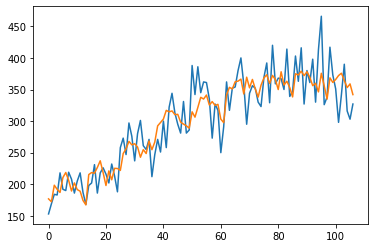

In [9]:
plot_eval(train_pred, y_train)

6006.533637442141


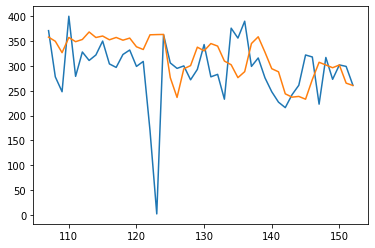

In [10]:

plot_eval(test_pred, y_test)
# why does it look like this???

In [11]:
from pandas.plotting import lag_plot, autocorrelation_plot

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

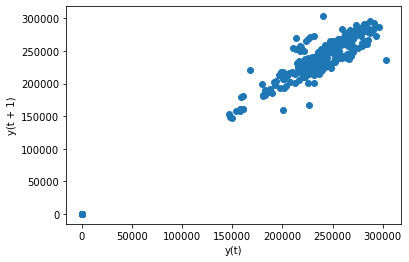

In [12]:
lag_plot(data, 1)

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

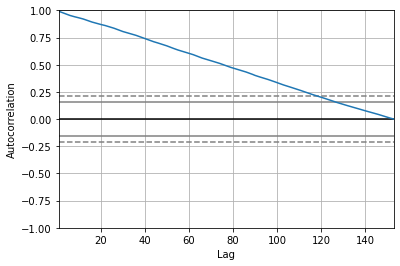

In [13]:
autocorrelation_plot(data)

In [14]:
cdf = pd.DataFrame(model.coef_, X.columns, columns=['importance'])


In [15]:
cdf

,importance
month,0.147260
altsales_lag3,16.249103
durable_lag9,0.000151
miles_lag12,0.000725
newhouses_lag3,-4.358211
ngf_lag12,-3.650890
XOM_lag12,0.830720


In [16]:
newdata = rollover(cdf)

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Features are named incorrectly, they are led 3 months ahead of their label


In [17]:
newdata

,month,altsales_lag3,durable_lag9,miles_lag12,newhouses_lag3,ngf_lag12,XOM_lag12
0,154,13.319,264356,285746,10.1,12.15,64.47
1,155,13.185,262494,267749,8.1,10.88,59.84
2,156,13.582,264258,268420,9.2,9.26,61.19


In [18]:
pred = model.predict(newdata)

In [19]:
# combine train, test, and pred into 1 df
full = bake_pred(y_train, y_test, pred)

In [20]:
full.to_csv("data/out/linear.csv")

In [21]:
full

,n,group
0,153.000000,train
1,169.000000,train
2,184.000000,train
3,183.000000,train
4,218.000000,train
...,...,...
151,299.000000,test
152,261.000000,test
153,269.087502,pred
154,263.242154,pred
